# General Andersen Box Extended Systems

## Nathan Zimmerberg

## 6 December 2019

Current GPU molecular dynamic simulation software, like OpenMM, use Monte Carlo barostats, these barostats scale the center of mass positions of molecules to transform the boundary box along any number of degrees of freedom, for example, volume or membrane area. They also allow target stationary distributions of those degrees of freedom. 

Despite their simplicity one issue with these barostats, is that the scaling is done in jumps using a Metropolis Hastings type accept or reject. This means that the potential energy function has to be calculated  after the scaling. This is not very simple to do given a general 3x3 matrix scaling. 

There is also concern that the jumps could have a large effect on dynamics, or other properties of the simulation.

The alternative to the Monte Carlo barostats is an extended system, where each box degree of freedom gets a momentum, and gets added to a new scaled hamiltonian.

The issue with this method is that it requires calculating the derivative of the potential energy with respect to scaling, here after called the virial on each force calculation. However, with a little book keeping about which image each force is from, the virial is not very computationally intesive, compared to the rest of the force calculation.

Here, I develop the theory needed to compare the Monte Carlo barostats to barostats using the Andersen method for molecular dynamic simulations at constant pressure and temperature.  For this purpose I will generalize the Andersen Barostat to work with a 3 x 3 scaling matrix that is a function of any number of box degrees of freedom. Also I will develop an explicit symplectic time reversible integrator for these extended systems, that works with optional nose hoover thermostat, and/or langevin thermostat on both atoms and box piston momementums. The integrator will also support most types of constraints. Lastly the integrator is fast, and conserves energy on 1 million atom liquid tip3 water simulation. 

## Simple Atomic System

### State

$\overrightarrow{r_1} ... \overrightarrow{r_N}$ atom positions.

$\overrightarrow{p_1} ... \overrightarrow{p_N}$ atom momentums.

$Q_1 ... Q_M$ box piston positions for example, volume, area, height, or others. Note while these are "positions" they don't need to have units of length.

$\Pi_1 ... \Pi_M$ box piston momentums for each box degree of freedom. Note while these are "momentums" they have units of mass * units of associated box piston position / units of time.

### Parameters

$m_1 ... m_N$ atom masses.

$M_1 ... M_M$ box piston masses.

$H(Q_1 ... Q_M)$ box matrix as a function of box piston positions. The H matrix is usually symetric, to avoid weird torques on the system.

$PE(\overrightarrow{r_1} ... \overrightarrow{r_N},H)$ atom potential energy function.

$PE_{box}(Q_1 ... Q_M)$ box potential energy, for example P * V.

### Target Stationary Probability Density Function

$f_{\overrightarrow{r_1} ... \overrightarrow{r_N},\overrightarrow{p_1} ... \overrightarrow{p_N},Q_1 ... Q_M,\Pi_1 ... \Pi_M}\propto
\exp\left(\frac{PE_{box}(Q_1 ... Q_M)+
\sum\limits_{i=1}^M \frac{\Pi_i^2}{2M_i}+
PE(\overrightarrow{r_1} ... \overrightarrow{r_N},H(Q_1 ... Q_M))+
\sum\limits_{i=1}^N \frac{\overrightarrow{p_i}^2}{2m_i}}{-kT}
\right)$

## Scaled Extended System

To get to the target stationary pdf, I used Andersen's method of creating an extended system where all of the atoms positions and momentums are scaled as the box is scaled. This is very useful for removing issues at the boundary that would come if the box was scaled without scaling the atom positions. (https://doi.org/10.1063/1.439486)

I have a slightly more general hamiltonian, because Andersen uses uniform scaling of a cube with volume as the only degree of freedom, while I use any number of degrees of freedom, on any shaped box, and scale by a 3x3 matrix, instead of uniform scaling. 

### State

$\overrightarrow{\rho_1} ... \overrightarrow{\rho_N}$ scaled atom positions.

$\overrightarrow{\pi_1} ... \overrightarrow{\pi_N}$ scaled atom momentums.

$\overrightarrow{r_i}= H\overrightarrow{\rho_i}$

$\overrightarrow{p_i}= H^{-T}\overrightarrow{\pi_i}$

$G=H^TH$

### Scaled Hamiltonian

$\mathcal{H_2}= \\
PE_{box}(Q_1 ... Q_M)+ \\
\sum\limits_{i=1}^M \frac{\Pi_i^2}{2M_i}+ \\
PE(H(Q_1 ... Q_M)\overrightarrow{\rho_1} ... H(Q_1 ... Q_M)\overrightarrow{\rho_N},H(Q_1 ... Q_M))+ \\
\sum\limits_{i=1}^N \frac{\overrightarrow{\pi_i}^TG^{-1}\overrightarrow{\pi_i}}{2m_i}
$

### System of Differential Equations

$\dot{\overrightarrow{\rho_i}} = \frac{\partial \mathcal{H_2}}{\partial \overrightarrow{\pi_i}} =\frac{G^{-1}}{m_i}\overrightarrow{\pi_i}$

$\dot{\overrightarrow{\pi_i}} = -\frac{\partial \mathcal{H_2}}{\partial \overrightarrow{\rho_i}} = H^T\overrightarrow{F_i}(H(Q_1 ... Q_M)\overrightarrow{\rho_1} ... H(Q_1 ... Q_M)\overrightarrow{\rho_N},H(Q_1 ... Q_M))$

$\dot{Q_i}=\frac{\partial \mathcal{H_2}}{\partial \Pi_i} = 
\frac{\Pi_i}{M_i}$

$\dot{\Pi_i}= -\frac{\partial \mathcal{H_2}}{\partial Q_i} = 
-\frac{\partial PE_{box}}{\partial Q_i} + 
2\langle H^{-1}\frac{\partial H}{\partial Q_i},3x3KE \rangle + 
\langle Virial\cdot H^{-T}, \frac{\partial H}{\partial Q_i} \rangle
$

Where 

$\overrightarrow{F_i}$ is the force on atom i.

$Virial = -\frac{\partial PE(H\overrightarrow{\rho_1} ... H\overrightarrow{\rho_N},H)}{\partial H}H^T$


$3x3KE = \sum\limits_{i=1}^N \frac{H^{-T}\overrightarrow{\pi_i}\overrightarrow{\pi_i}^TH^{-1}}{2m_i}$

### Unscaled Differential Equations

$\dot{\overrightarrow{r_i}}=\frac{\overrightarrow{p_i}}{m_i}+\dot{H}H^{-1}\overrightarrow{r_i}$

$\dot{\overrightarrow{p_i}}=\overrightarrow{F_i}-
\left(\dot{H}H^{-1}\right)^T\overrightarrow{p_i}$

### Proof that the target distribution is stationary

Because the scaled system evolves according to the scaled hamiltonial
$\mathcal{H_2}$ it has a stationary distrobution of:

$f_{\overrightarrow{\rho_1} ... \overrightarrow{\rho_N},\overrightarrow{\pi_1} ... \overrightarrow{\pi_N},Q_1 ... Q_M,\Pi_1 ... \Pi_M}\propto
\exp\left(\frac{\mathcal{H_2}}{-kT}
\right)$

To do a change of variables to get back to unscaled coordinates, the density function needs to be multiplied by the determinant of the jacobian. Lukily(by design of Andersen) the determinant of the jacobian of the transformation is one, because the momentums are scaled in an inverse way as the positions.

Therefor,

$f_{\overrightarrow{r_1} ... \overrightarrow{r_N},\overrightarrow{p_1} ... \overrightarrow{p_N},Q_1 ... Q_M,\Pi_1 ... \Pi_M}\propto
\exp\left(\frac{PE_{box}(Q_1 ... Q_M)+
\sum\limits_{i=1}^M \frac{\Pi_i^2}{2M_i}+
PE(\overrightarrow{r_1} ... \overrightarrow{r_N},H(Q_1 ... Q_M))+
\sum\limits_{i=1}^N \frac{\overrightarrow{p_i}^2}{2m_i}}{-kT}
\right)$

Which is just a change of variables of

$f_{\overrightarrow{\rho_1} ... \overrightarrow{\rho_N},\overrightarrow{\pi_1} ... \overrightarrow{\pi_N},Q_1 ... Q_M,\Pi_1 ... \Pi_M}\propto
\exp\left(\frac{\mathcal{H_2}}{-kT}
\right)$

is a stationary distrobution of the system.


## Adding Constraints

It is very simple to add rigid body constraints, or small non rigid body constriants to this system. The system scales constrained groups by Center Of Mass (COM). This leads to different dynamics from a system where all atoms are scaled, then constraints reapplied. However, for rigid body constraints the dynamics are identical, and for other constraints, both systems have the same stationary distribution.

### Modifications to the State

$\overrightarrow{r_1} ... \overrightarrow{r_N}$ molecule (COM) positions.

$\overrightarrow{p_1} ... \overrightarrow{p_N}$ molecule (COM) momentums.

$\pmb{q}_1 ... \pmb{q}_N$ molecule internal and rotational degrees of freedom, note that these don't have to be scalars.

$\pmb{\beta}_1 ... \pmb{\beta}_N$ molecule internal and rotational degrees of freedom momentums note that these don't have to be scalars.

### Modifications to the Parameters

$m_1 ... m_N$ molecule masses.

$J_1 ... J_N$ molecule internal and rotational inertials.

$PE(\overrightarrow{r_1} ... \overrightarrow{r_N},H,\pmb{q}_1 ... \pmb{q}_N)$ atom potential energy function.

### New Target Distribution

$f_{\overrightarrow{r_1} ... \overrightarrow{r_N},\overrightarrow{p_1} ... \overrightarrow{p_N},Q_1 ... Q_M,\Pi_1 ... \Pi_M,\pmb{q}_1 ... \pmb{q}_N,\pmb{\beta}_1 ... \pmb{\beta}_N}\propto \\
\exp\left(\frac{PE_{box}(Q_1 ... Q_M)+
\sum\limits_{i=1}^M \frac{\Pi_i^2}{2M_i}+
PE(\overrightarrow{r_1} ... \overrightarrow{r_N},H,\pmb{q}_1 ... \pmb{q}_N)+
\sum\limits_{i=1}^N \frac{\overrightarrow{p_i}^2}{2m_i}
+ KE_{internal}(\pmb{\beta}_1 ... \pmb{\beta}_N)}{-kT}
\right)$

### Modifications to the Hamiltonian

Just add in the $KE_{internal}(\pmb{\beta}_1 ... \pmb{\beta}_N)$ and use the new PE function, don't scale the internal degrees of freedom, only the centers of mass.

## Adding Nose Hoover Thermostat

The MKS method adds a hoover thermostat to the box piston as well as the atoms. But there is no good reason to do this, the box piston can be thermostated with langevan dynamics instead. The Nose Hoover thermostat here is added only to the atoms, using the method described in Hoover's paper (https://doi.org/10.1103/PhysRevA.31.1695)

The new system in no longer hamiltonian, but the dynamics can still be expressed in terms of the hamiltonian, with an added friction term on some of the momentums.

### Modifiactions To System of Differential Equations

$\dot{\overrightarrow{\pi_i}} = -\frac{\partial \mathcal{H_2}}{\partial \overrightarrow{\rho_i}} - \xi*\overrightarrow{\pi_i}$

$\dot{\pmb{\beta}_i} = -\frac{\partial \mathcal{H_2}}{\partial \pmb{q}_i} - \xi*\pmb{\beta}_i$

$\dot{\xi}=\frac{2*KE_{internal}(\pmb{\beta}_1 ... \pmb{\beta}_N)+\sum\limits_{i=1}^N \frac{\overrightarrow{\pi_i}^TG^{-1}\overrightarrow{\pi_i}}{m_i}}{D}$

Where D is the Nose Hoover mass, and $\xi$ is Nose Hoover velocity.

### Final Target Distribution

$f_{\overrightarrow{r_1} ... \overrightarrow{r_N},\overrightarrow{p_1} ... \overrightarrow{p_N},Q_1 ... Q_M,\Pi_1 ... \Pi_M,\pmb{q}_1 ... \pmb{q}_N,\pmb{\beta}_1 ... \pmb{\beta}_N,\xi}\propto \\
\exp\left(\frac{PE_{box}(Q_1 ... Q_M)+
\sum\limits_{i=1}^M \frac{\Pi_i^2}{2M_i}+
PE(\overrightarrow{r_1} ... \overrightarrow{r_N},H,\pmb{q}_1 ... \pmb{q}_N)+
\sum\limits_{i=1}^N \frac{\overrightarrow{p_i}^2}{2m_i} + KE_{internal}(\pmb{\beta}_1 ... \pmb{\beta}_N) + \frac{1}{2}D\xi^2}{-kT}
\right)$

It can be proved that this distribution is stationary in the final modified system, using Hoover's method along with a change of variables to the scaled coordinates.






## Andersen Barostat Example

There is only one degree of freedom, $Q$ which is the volume of the cube.

$H(Q)=
\begin{bmatrix}
Q^{\frac{1}{3}}&0&0\\
0&Q^{\frac{1}{3}}&0\\
0&0&Q^{\frac{1}{3}}
\end{bmatrix}$

$\dot{H}=
\begin{bmatrix}
\frac{1}{3}\dot{Q}Q^{\frac{-2}{3}}&0&0\\
0&\frac{1}{3}\dot{Q}Q^{\frac{-2}{3}}&0\\
0&0&\frac{1}{3}\dot{Q}Q^{\frac{-2}{3}}
\end{bmatrix}$

$PE_{box}(Q)= P_{ref}Q$

$\mathcal{H_2}= \\
PE_{box}(Q_1 ... Q_M)+ \\
\sum\limits_{i=1}^M \frac{\Pi_i^2}{2M_i}+ \\
PE(H(Q_1 ... Q_M)\overrightarrow{\rho_1} ... H(Q_1 ... Q_M)\overrightarrow{\rho_N},H(Q_1 ... Q_M))+ \\
\sum\limits_{i=1}^N \frac{\overrightarrow{\pi_i}^TG^{-1}\overrightarrow{\pi_i}}{2m_i}
$

$\mathcal{H_2}= \\
P_{ref}Q+ \\
\frac{\Pi^2}{2M}+ \\
PE(Q^{\frac{1}{3}}\overrightarrow{\rho_1} ... Q^{\frac{1}{3}}\overrightarrow{\rho_N},H(Q))+ \\
\sum\limits_{i=1}^N \frac{\overrightarrow{\pi_i}^TQ^{\frac{-2}{3}}\overrightarrow{\pi_i}}{2m_i}
$

Which exactly matches equation 3.6 from Andersen's paper(ref)



## Zhang et al.: Extended Systems Example

In Zhang et al.: Computer simulation of liquid/liquid interfaces. I (ref) 4 different extended systems are created, they all assume an orthogonal box, so the H matrix is diagonal.

$H(h_x,h_y,h_z)=
\begin{bmatrix}
h_x&0&0\\
0&h_y&0\\
0&0&h_z
\end{bmatrix}$

### NP<sub>n</sub>AT

$PE_{box}(h_z)= P_{n0}h_xh_yh_z$

Where $h_x$ and $h_y$ are parameters.

$\dot{Q_i}=\frac{\partial \mathcal{H_2}}{\partial \Pi_i} = 
\frac{\Pi_i}{M_i}$

$\dot{\Pi_i}= -\frac{\partial \mathcal{H_2}}{\partial Q_i} = 
-\frac{\partial PE_{box}}{\partial Q_i} + 
2\langle H^{-1}\frac{\partial H}{\partial Q_i},3x3KE \rangle + 
\langle Virial\cdot H^{-T}, \frac{\partial H}{\partial Q_i} \rangle
$

$\dot{\overrightarrow{r_i}}=\frac{\overrightarrow{p_i}}{m_i}+\dot{H}H^{-1}\overrightarrow{r_i}$

$\dot{\overrightarrow{p_i}}=\overrightarrow{F_i}-
\left(\dot{H}H^{-1}\right)^T\overrightarrow{p_i}$

$\dot{H}H^{-1}=
\begin{bmatrix}
0&0&0\\
0&0&0\\
0&0&\frac{\dot{h_z}}{h_z}
\end{bmatrix}$


$\dot{p}_{xi}=F_{xi}$

$\dot{p}_{yi}=F_{yi}$

$\dot{p}_{zi}=F_{zi}-
\frac{\dot{h_z}}{h_z}p_{zi}$

$\dot{r}_{xi}=\frac{p_{xi}}{m_i}$

$\dot{r}_{yi}=\frac{p_{yi}}{m_i}$

$\dot{r}_{zi}=\frac{p_{zi}}{m_i}+\frac{\dot{h_z}}{h_z}r_{zi}$

$\frac{\partial H}{\partial h_z}=
\begin{bmatrix}
0&0&0\\
0&0&0\\
0&0&1
\end{bmatrix}$

$\dot{\Pi}= -\frac{\partial \mathcal{H_2}}{\partial h_z} = 
-P_{n0}h_xh_y + 
2 \frac{3x3KE_{zz}}{h_z} + 
\frac{Virial_{zz}}{h_z}
$

Factoring out a $h_xh_y$
and noting that $\dot{\Pi}=M\ddot{h_z}$ and $V=h_xh_yh_z$

$M\ddot{h}_z=h_xh_y (2 \frac{3x3KE_{zz}}{V} + 
\frac{Virial_{zz}}{V}-P_{n0})$

Which exactly matches equation 3.3 from Zhang et al's paper(ref)

### NV$\gamma$T

$H(h_x,h_y)=
\begin{bmatrix}
h_x&0&0\\
0&h_y&0\\
0&0&\frac{V}{h_xh_y}
\end{bmatrix}$

Where V is the constant volume of the box.

$PE_{box}(h_x,h_y)= -\gamma_0h_xh_y$

$\dot{H}=
\begin{bmatrix}
\dot{h_x}&0&0\\
0&\dot{h_y}&0\\
0&0&-\frac{V}{h_xh_y}\left(\frac{\dot{h_x}}{h_x} + \frac{\dot{h_y}}{h_y}\right)
\end{bmatrix}$

$\dot{H}H^{-1}=
\begin{bmatrix}
\frac{\dot{h_x}}{h_x}&0&0\\
0&\frac{\dot{h_y}}{h_y}&0\\
0&0&-\left(\frac{\dot{h_x}}{h_x} + \frac{\dot{h_y}}{h_y}\right)
\end{bmatrix}$

$\dot{\overrightarrow{r_i}}=\frac{\overrightarrow{p_i}}{m_i}+\dot{H}H^{-1}\overrightarrow{r_i}$

$\dot{\overrightarrow{p_i}}=\overrightarrow{F_i}-
\left(\dot{H}H^{-1}\right)^T\overrightarrow{p_i}$

These match up with equation 3.12 from Zhang et al's paper(ref) if the matrix multiplication is done out.

$\frac{\partial H}{\partial h_x}=
\begin{bmatrix}
1&0&0\\
0&0&0\\
0&0&-\frac{V}{h_x^2h_y}
\end{bmatrix}$

$\dot{\Pi_i}= -\frac{\partial \mathcal{H_2}}{\partial Q_i} = 
-\frac{\partial PE_{box}}{\partial Q_i} + 
2\langle H^{-1}\frac{\partial H}{\partial Q_i},3x3KE \rangle + 
\langle Virial\cdot H^{-T}, \frac{\partial H}{\partial Q_i} \rangle
$

$\dot{\Pi_x}= -\frac{\partial \mathcal{H_2}}{\partial h_x} = 
\gamma_0h_y + 
2 \frac{3x3KE_{xx}}{h_x} - 2 \frac{3x3KE_{zz}}{h_x} + 
\frac{Virial_{xx}}{h_x}-\frac{Virial_{zz}}{h_x}
$

Factoring out an $h_y$
and noting that $\dot{\Pi_x}=M_x\ddot{h}_x$ and $V=h_xh_yh_z$

$M\ddot{h}_x=h_y \left(\gamma_0 - h_z \left(\frac{Virial_{zz}}{V}+2 \frac{3x3KE_{zz}}{V}-\frac{Virial_{xx}}{V}-2\frac{3x3KE_{xx}}{V} \right)\right)$
This matchs up with equation 3.12 from Zhang et al's paper(ref).


## Nose-Klein Extended Systems Example

For Nose-Klein each element of $H$ is a degree of freedom with mass $W$ (ref)

$PE_{box}(H)= P_{ex}det(H)$

&nbsp;

$\mathcal{H_2}= \\
PE_{box}(Q_1 ... Q_M)+ \\
\sum\limits_{i=1}^M \frac{\Pi_i^2}{2M_i}+ \\
PE(H(Q_1 ... Q_M)\overrightarrow{\rho_1} ... H(Q_1 ... Q_M)\overrightarrow{\rho_N},H(Q_1 ... Q_M),\pmb{q}_1 ... \pmb{q}_N)+ \\
KE_{internal}(\pmb{\beta}_1 ... \pmb{\beta}_N)+\\
\sum\limits_{i=1}^N \frac{\overrightarrow{\pi_i}^TG^{-1}\overrightarrow{\pi_i}}{2m_i}
$

&nbsp;

$\dot{\overrightarrow{\rho_i}} =\frac{G^{-1}}{m_i}\overrightarrow{\pi_i}$

&nbsp;

$\mathcal{H_2}= \\
P_{ex}V+ \\
\sum\limits_{i,j} \frac{W\dot{H}_{ij}^2}{2}+ \\
PE(\overrightarrow{r_1} ... \overrightarrow{r_N},H,\pmb{q}_1 ... \pmb{q}_N)+ \\
\sum\limits_{i=1}^N m_i\frac{\dot{\overrightarrow{\rho_i}}^TG\dot{\overrightarrow{\rho_i}}}{2}
$

This matches up with the hamiltonian 2.12 from Nose-Klein.

# Integrator

$\mathcal{H_2}$ is the general hamiltonian for all of the above ensembles.
So a good integrator for $\mathcal{H_2}$ simplifies the task of implementing all of the above ensembles in CUDA.

### Requirements
1. Fast: The integrator has to only use one force and all atom virial calculation each timestep.
2. Determanistic: Given a seed and initial conditions, the integrator must not have different behavior on different computers.
3. Phase space metric preserving: The integrator should preserve the phase space metric down to double precision rounding errors.
4. Reversible: The intergrator should be reversible down to double precision rounding errors.
5. Conserve high frequency corrected total energy: This is a measure of the numerical stability of the integrator, and a good way to check for bugs in the code.

### Full Unfolded Integrator

To make this integrator, I started by just using a kick drift leap frog like integration directly on the scaled system. Because there are many more types of state besides just atom position and momentum, there are many different possible orderings of the integrator, I tried a few of them out on a small 125 atom argon gas system in python. The ordering didn't seem to have a huge impact on energy conservation for the argon system. For the CUDA integrator, I just choose and ordering that was easiest to implement when constraints are included. 

The integrator is composed of kick and drift steps, with optional thermostating at the half steps.

The kick step is supposed to be an application of the potential, in an impulse.

The drift step is supposed to be an evolution of the system without a potential.

The kick and drift steps are approximations of the real kick and drift, because there is no simple explicit solution for the kick or drift for the extended system with constraints.

#### Kick step in scaled coordinates.
 
 * $\overrightarrow{\pi_i} \mathrel{+}= H^T\overrightarrow{F_i}\Delta t$
 * internal momentum update
 * $\Pi_i \mathrel{+}= F_{virial\:i}\Delta t$
 
Where 

$\overrightarrow{F_i}$ is the net force on molecule i.

$F_{virial\:i}=\langle Virial\cdot H^{-T}, \frac{\partial H}{\partial Q_i} \rangle$

$Virial = -\frac{\partial PE(H\overrightarrow{\rho_1} ... H\overrightarrow{\rho_N},H)}{\partial H}H^T$ is the virial, corrected to not include scaling inside a molecule, only molecule centers of mass.

#### Drift step in scaled coordinates.

1. $\Pi_i \mathrel{+}= \left(F_{KE\:i}+F_{pres\:i}\right)\frac{\Delta t}{2}$
2. $Q_i \mathrel{+}= \frac{\Pi_i}{M_i}\frac{\Delta t}{2}$
3. 
    * $\overrightarrow{\rho_i} \mathrel{+}= \frac{G^{-1}}{m_i}\overrightarrow{\pi_i}\Delta t$
    * internal degrees of freedom drift
4. $Q_i \mathrel{+}= \frac{\Pi_i}{M_i}\frac{\Delta t}{2}$
5. $\Pi_i \mathrel{+}= \left(F_{KE\:i}+F_{pres\:i}\right)\frac{\Delta t}{2}$

Where 

$F_{pres\:i}=-\frac{\partial PE_{box}}{\partial Q_i}$

$F_{KE\:i}=2\langle H^{-1}\frac{\partial H}{\partial Q_i},3x3KE \rangle$

$3x3KE = \sum\limits_{i=1}^N \frac{H^{-T}\overrightarrow{\pi_i}\overrightarrow{\pi_i}^TH^{-1}}{2m_i}$ is the matrix of the kinetic energy from the net linear momentums of the molecules.

### Phase Space Volume Preservation

Each update step in the integrator, except for internal coordinates, is in the form $x \mathrel{+}= f(\pmb{y})$ where $x$ is one state of the system, and $\pmb{y}$ a vector of all the other states of the system, excluding $x$. This type  of transformation always preserves phase space volume. Since the integration is composed of these types of steps and internal coordinate updates the total integrator will also preserve volume if the internal coordinates are updated in a volume preserving way.

### Thermostating

The optional Nose Hoover vscale is being used as described in "Explicit reversible integrators for extended systems dynamics" by Martyna et al. (ref) equation (26).

The optional Ornstein Uhlenbeck can be done like in between the drift steps BAOAB or in between the kick steps.

The Ornstein Uhlenbeck/Andersen thermostat can be done on any momentum terms that are independent and normally distributed in the target stationary distribution, or any change of variables of the target stationary distribution, this includes the box piston momentums and the Nose Hoover piston velocity, as well as atom  or molecule pairwise or absolute momentums.

There is no real good reason to add Nose Hoover thermostats to the box pistons, or to have a Nose Hoover chain. Nose Hoover is useful because, unlike Langevin (implemented in discrete time with Ornstein Uhlenbeck) or Andersen thermostats, Nose Hoover scales the velocity of all atoms together, so it doesn't have a large effect on dynamics. There are at most six box pistons, and the exact dynamics of these pistons are not very important, because they are not real pistons. Langevin dynamics on the box piston as described in (ref to Langevin Piston paper) work well to dampen out box piston oscillations if the simulation starts far from equilibrium.

Here is the integrator with thermostating.
1. optional half time step Nose Hoover vscale
2. optional half time step Ornstein Uhlenbeck/Andersen thermostat
3. half time step kick
4. half time step drift
5. optional full time step Ornstein Uhlenbeck/Andersen thermostat
6. half time step drift
7. Update forces and virial
8. half time step kick
9. optional half time step Ornstein Uhlenbeck/Andersen thermostat
10. optional half time step Nose Hoover vscale



### Folded Integrator

This is the same integrator as the unfolded integrator, just written in a form that is easily executable on a graphics card. This integrator is also folded to be leap frog like.
<img src="graph_cuda.pdf">

###  Drift of Unscaled Coordinates

While scaled coordinates are nice for writing out the hamiltonian and the integrator, the actual implemented integrator uses unscaled coordinates for compatibility with the rest of CHARMM and the force calculation.

Here is the super inefficent way of doing the integrator.
First just scale before the drift then unscale after. 
1. 
    * $H_0 \Leftarrow H$
    * $\overrightarrow{\pi_i} \Leftarrow H_0^T\overrightarrow{p_i}$
    * $\overrightarrow{\rho_i} \Leftarrow H_0^{-1}\overrightarrow{r_i}$
    * calculate $H_1$, the H matrix at the half step, and $H_2$ the H matrix after the full step.
2. 
    * $\overrightarrow{\rho_i} \mathrel{+}= \frac{\left(H_1^T H_1\right)^{-1}}{m_i}\overrightarrow{\pi_i}\Delta t$
    * internal degrees of freedom drift
    
3.  
    * $H \Leftarrow H_2$
    * $\overrightarrow{p_i} \Leftarrow H_2^{-T}\overrightarrow{\pi_i}$
    * $\overrightarrow{r_i} \Leftarrow H_2\overrightarrow{\rho_i}$
    
    
This can be simplified to not use scaled coordinates at all.

1. calculate $H_1$, the H matrix at the half step, and $H_2$ the H matrix after the full step.
1. 
    * $\overrightarrow{r_i} \Leftarrow H_2H_0^{-1}\overrightarrow{r_i} + H_2\left(H_1^T H_1\right)^{-1}H_0^{T}\frac{\overrightarrow{p_i}}{m_i}\Delta t$
    * $\overrightarrow{p_i} \Leftarrow H_2^{-T}H_0^{T}\overrightarrow{p_i}$

Let

$r\:prescale = H_2H_0^{-1}$

$v\:prescale = H_2\left(H_1^T H_1\right)^{-1}H_0^{T}$

$v\:scale = H_2^{-T}H_0^{T}$

Then the drift step is just:
 * $\overrightarrow{r_i} \Leftarrow {r\:prescale} \cdot \overrightarrow{r_i} + {v\:prescale} \cdot \frac{\overrightarrow{p_i}}{m_i}\Delta t$
 * $\overrightarrow{p_i} \Leftarrow {v\:scale} \cdot \overrightarrow{p_i}$

The goal of the box piston class is to calculate these scaling factors.

There are two main types, orthogonal scaling and symetric 3x3 matrix scaling.


In [184]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.integrate import solve_ivp

In [134]:
#Andersen Barostat Example
class AndersenBarostat(object):
    """Andersen Barostat"""
    def __init__(self,piston_mass=1,pressure=1,gamma=1,prob=1):
        """Initializes the Andersen Barostat
        args
            piston_mass(float):
                dimensions of mass/length^4
            pressure(float):
                units are not atms, it is SI compatible with other units."""
        self.piston_mass= piston_mass
        self.pressure= pressure
        self.gamma= gamma
        self.prob= prob
        
    def pe(self,box):
        """Return the potential energy of the box"""
        return self.pressure*box[0][0]**3
    
    def ke(self,box,box_dot):
        """Return the kinetic energy of the box"""
        volume_dot= box_dot[0][0]*box[0][0]**2*3
        return 0.5*self.piston_mass*volume_dot**2
    
    def drift(self,com_ke,box,box_dot,timestep):
        """Return a tuple of new_com_ke,new_box,new_box_dot,v_scale,v_prescale,r_prescale after a drift"""
        volume_dot= box_dot[0][0]*box[0][0]**2*3
        volume= box[0][0]**3
        f_pres= -self.pressure
        f_ke= 2/3/volume*(com_ke.trace())
        volume_dot+= (f_pres+f_ke)/self.piston_mass*timestep*0.5
        volume0= volume
        volume1= volume0+volume_dot*timestep*0.5
        volume2= volume0+volume_dot*timestep
        volume= volume2
        r_prescale= np.eye(3)*(volume2**(1/3)/volume0**(1/3))
        v_prescale= np.eye(3)*(volume2**(1/3)*volume0**(1/3)/volume1**(2/3))
        v_scale= np.eye(3)*(volume0**(1/3)/volume2**(1/3))
        new_com_ke= com_ke*(volume0**(2/3)/volume2**(2/3))
        f_pres= -self.pressure
        f_ke= 2/3/volume*(new_com_ke.trace())
        volume_dot+= (f_pres+f_ke)/self.piston_mass*timestep*0.5
        new_box= np.eye(3)*volume**(1/3)
        new_box_dot= np.eye(3)*(volume_dot/volume**(2/3)/3)
        return(new_com_ke,new_box,new_box_dot,v_scale,v_prescale,r_prescale)
            
    def virialKick(self,virial,box,box_dot,timestep):
        """Return new_box_dot after the virial kick"""
        volume= box[0][0]**3
        f_virial= 1/3/volume*(virial.trace())
        volume_dot= box_dot[0][0]*box[0][0]**2*3
        volume_dot+= (f_virial)/self.piston_mass*timestep
        new_box_dot= np.eye(3)*(volume_dot/box[0][0]**(2))/3
        return new_box_dot
    
    def thermostat(self,temperature,box,box_dot,timestep):
        """Return new_box_dot after the thermostat kick"""
        volume= box[0][0]**3
        volume_dot= box_dot[0][0]*box[0][0]**2*3
        if(np.random.rand()<self.prob):   
            volume_dot*= np.exp(-self.gamma*timestep)
            volume_dot+= np.sqrt(1.0-np.exp(-2.0*self.gamma*timestep))*np.sqrt(temperature/self.piston_mass)*np.random.randn()
        new_box_dot= np.eye(3)*(volume_dot/box[0][0]**(2))/3
        return new_box_dot

In [168]:
#LengthPiston Example
class LengthPiston(object):
    """LengthPiston"""
    def __init__(self,piston_mass=1,pressure=1,gamma=1,prob=1):
        """Initializes the Length Piston"""
        self.piston_mass= piston_mass
        self.pressure= pressure
        self.gamma= gamma
        self.prob= prob
        
    def pe(self,box):
        """Return the potential energy of the box"""
        return self.pressure*box[0][0]**3
    
    def ke(self,box,box_dot):
        """Return the kinetic energy of the box"""
        len_dot= box_dot[0][0]
        return 0.5*self.piston_mass*len_dot**2
    
    def drift(self,com_ke,box,box_dot,timestep):
        """Return a tuple of new_com_ke,new_box,new_box_dot,v_scale,v_prescale,r_prescale after a drift"""
        boxlen_dot= box_dot[0][0]
        boxlen= box[0][0]
        f_pres= -3*self.pressure*boxlen**2
        f_ke= 2/boxlen*(com_ke.trace())
        boxlen_dot+= (f_pres+f_ke)/self.piston_mass*timestep*0.5
        boxlen0= boxlen
        boxlen1= boxlen0+boxlen_dot*timestep*0.5
        boxlen2= boxlen0+boxlen_dot*timestep
        boxlen= boxlen2
        r_prescale= np.eye(3)*(boxlen2/boxlen0)
        v_prescale= np.eye(3)*(boxlen2*boxlen0/boxlen1**2)
        v_scale= np.eye(3)*(boxlen0/boxlen2)
        new_com_ke= com_ke*(boxlen0/boxlen2)**2
        f_pres= -3*self.pressure*boxlen**2
        f_ke= 2/boxlen*(new_com_ke.trace())
        boxlen_dot+= (f_pres+f_ke)/self.piston_mass*timestep*0.5
        new_box= np.eye(3)*boxlen
        new_box_dot= np.eye(3)*boxlen_dot
        return(new_com_ke,new_box,new_box_dot,v_scale,v_prescale,r_prescale)
            
    def virialKick(self,virial,box,box_dot,timestep):
        """Return new_box_dot after the virial kick"""
        boxlen= box[0][0]**3
        f_virial= 1/boxlen*(virial.trace())
        boxlen_dot= box_dot[0][0]
        boxlen_dot+= (f_virial)/self.piston_mass*timestep
        new_box_dot= np.eye(3)*boxlen_dot
        return new_box_dot
    
    def thermostat(self,temperature,box,box_dot,timestep):
        """Return new_box_dot after the thermostat kick"""
        boxlen= box[0][0]**3
        boxlen_dot= box_dot[0][0]
        if(np.random.rand()<self.prob):   
            boxlen_dot*= np.exp(-self.gamma*timestep)
            boxlen_dot+= np.sqrt(1.0-np.exp(-2.0*self.gamma*timestep))*np.sqrt(temperature/self.piston_mass)*np.random.randn()
        new_box_dot= np.eye(3)*boxlen_dot
        return new_box_dot

In [169]:
def ideal_gas_test_NPE(box_piston,initial_box,initial_box_dot,initial_ke3x3,timestep,steps):
    """Returns an array of time, box length, volumes, particle kinetic energy, box kinetic energy, box potential energy, and total energy"""
    out_array=[]
    com_ke= initial_ke3x3[:]
    box= initial_box[:]
    box_dot= initial_box_dot[:]
    for i in range(steps):
        (com_ke,box,box_dot,v_scale,v_prescale,r_prescale)=box_piston.drift(com_ke,box,box_dot,timestep)
        out_array.append([i*timestep,box[0][0],box[0][0]**3,com_ke.trace(),box_piston.ke(box,box_dot),box_piston.pe(box),com_ke.trace()+box_piston.ke(box,box_dot)+box_piston.pe(box)])
    return out_array
        

In [173]:
def ideal_gas_test_NPT(temperature,box_piston,initial_box,initial_box_dot,timestep,steps):
    """Returns an array of time, box length, volumes, particle kinetic energy, box kinetic energy, box potential energy, and total energy"""
    out_array=[]
    box= initial_box[:]
    box_dot= initial_box_dot[:]
    num_atoms=50
    mass=1
    atom_vs= np.sqrt(temperature/mass)*np.random.randn(num_atoms,3)
    com_ke= sum([np.outer(v,v) for v in atom_vs])*0.5*mass
    gamma = 0.1
    
    for i in range(steps):
        (com_ke,box,box_dot,v_scale,v_prescale,r_prescale)=box_piston.drift(com_ke,box,box_dot,timestep*0.5)
        box_dot=box_piston.thermostat(temperature,box,box_dot,timestep)
        atom_vs = np.matmul(v_scale,atom_vs.transpose()).transpose()
        atom_vs*= np.exp(-gamma*timestep)
        atom_vs+= np.sqrt(1.0-np.exp(-2.0*gamma*timestep))*np.sqrt(temperature/mass)*np.random.randn(num_atoms,3)
        com_ke= sum([np.outer(v,v) for v in atom_vs])*0.5*mass
        (com_ke,box,box_dot,v_scale,v_prescale,r_prescale)=box_piston.drift(com_ke,box,box_dot,timestep*0.5)
        atom_vs = np.matmul(v_scale,atom_vs.transpose()).transpose()
        com_ke= sum([np.outer(v,v) for v in atom_vs])*0.5*mass
        out_array.append([i*timestep,box[0][0],box[0][0]**3,com_ke.trace(),box_piston.ke(box,box_dot),box_piston.pe(box),com_ke.trace()+box_piston.ke(box,box_dot)+box_piston.pe(box)])
    return out_array

25.445142298506152
24.965605195209836
3.5423106558834094


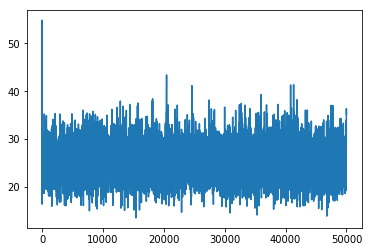

In [214]:
xv=ideal_gas_test_NPT(0.5,AndersenBarostat(piston_mass=1,pressure=1,gamma=0.1),np.eye(3)*25**(1/3),np.eye(3)*0.3,0.05,1000000)
#plt.plot(np.array(x)[:,0],np.array(x)[:,-1])
plt.plot(np.array(xv)[:,0],np.array(xv)[:,2])
print(np.mean(np.array(xv)[1000:,2]))
print(np.mean(np.array(xv)[1000:,3])*2/3)
print(np.std(np.array(xv)[1000:,2]))

25.13240079512375
24.99067924256549
3.497768284164138


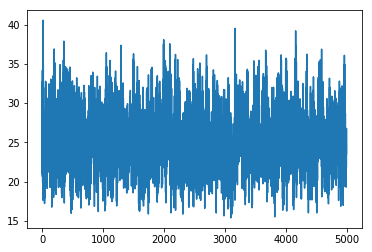

In [215]:
xl=ideal_gas_test_NPT(0.5,LengthPiston(piston_mass=10,pressure=1,gamma=0.1,prob=1),np.eye(3)*25**(1/3),np.eye(3)*0.3,0.05,100000)
#plt.plot(np.array(x)[:,0],np.array(x)[:,-1])
plt.plot(np.array(xl)[:,0],np.array(xl)[:,2])
print(np.mean(np.array(xl)[1000:,2]))
print(np.mean(np.array(xl)[1000:,3])*2/3)
print(np.std(np.array(xl)[1000:,2]))

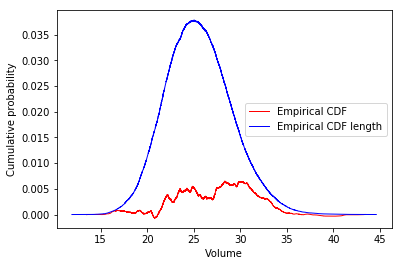

In [216]:
#MCMC Barostat, vscale version
# cdf P(volume)
# 1.0-3.28795E-65*sp.special.gammainc(51, 2*volume)
q= np.linspace(15,50,1000)
p= sp.special.gammainc(51, 2*q)
#from
#https://stackoverflow.com/questions/33345780/empirical-cdf-in-python-similiar-to-matlabs-one
def ecdf(sample):

    # convert sample to a numpy array, if it isn't already
    sample = np.atleast_1d(sample)

    # find the unique values and their corresponding counts
    quantiles, counts = np.unique(sample, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    cumprob = np.cumsum(counts).astype(np.double) / sample.size

    return quantiles, cumprob
# compute the ECDF of the samples
qe, pe = ecdf(np.array(xv)[1000:,2])
qel, pel = ecdf(np.array(x)[1000:,2])
pe= pe - sp.special.gammainc(51, 2*qe)
pel= pel - sp.special.gammainc(51, 2*qel)
# plot
fig, ax = plt.subplots(1, 1)
#ax.hold(True)
#ax.plot(q, p, '-k', lw=1, label='Theoretical CDF')
ax.plot(qe, pe, '-r', lw=1, label='Empirical CDF')
ax.plot(qel, pel, '-b', lw=1, label='Empirical CDF length')
ax.set_xlabel('Volume')
ax.set_ylabel('Cumulative probability')
ax.legend(fancybox=True, loc='right')

plt.show()

<img src="plot_of_energies.pdf">
<img src="plot_of_total_energy.pdf">

# TODO add graphs for tip3 system with constraints, and add python code to check difference between box length and box volume degrees of freedom.